### Descrição - Modelo Time Dependent (ETS/ARIMA)

Separa todo o conjunto de dados fornecidos ``train.csv`` para divider em treinamento e teste. Utiliza modelos **ETS** e **ARIMA** para regressão temporal e forecasting


### Libraries

In [1]:
from warnings import simplefilter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
from random import sample
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

simplefilter("ignore")

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(10, 6),
    titlesize=18,
    titleweight='bold'
    )
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
    )
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    )


### Import dataset

In [3]:
cols = ["cfips", "microbusiness_density", "active"]
train = pd.read_csv('./files/train.csv',
                      usecols=["first_day_of_month"] + cols,
                      parse_dates=['first_day_of_month'],
                      index_col='first_day_of_month',
                      ).to_period('D').reindex(columns=cols)

train.index.names = ['Month']
# retail = pd.concat({'Sales': retail}, names=[None, 'Industries'], axis=1)
train_df = train.drop("active", axis=1)

print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 122265 entries, 2019-08-01 to 2022-10-01
Freq: D
Data columns (total 2 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   cfips                  122265 non-null  int64  
 1   microbusiness_density  122265 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.8 MB
None


,cfips,microbusiness_density
Month,,
2019-08-01,1001,3.007682
2019-09-01,1001,2.884870
2019-10-01,1001,3.055843
2019-11-01,1001,2.993233
2019-12-01,1001,2.993233


In [4]:
test_df = pd.read_csv('./files/test.csv')
samp_sub_df = pd.read_csv('./files/sample_submission.csv')
display(test_df.head())
display(samp_sub_df.head())
samp_sub_df.info()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


,row_id,microbusiness_density
0,1001_2022-11-01,3.817671
1,1003_2022-11-01,3.817671
2,1005_2022-11-01,3.817671
3,1007_2022-11-01,3.817671
4,1009_2022-11-01,3.817671


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25080 entries, 0 to 25079
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   row_id                 25080 non-null  object 
 1   microbusiness_density  25080 non-null  float64
dtypes: float64(1), object(1)
memory usage: 392.0+ KB


<AxesSubplot:xlabel='Month'>

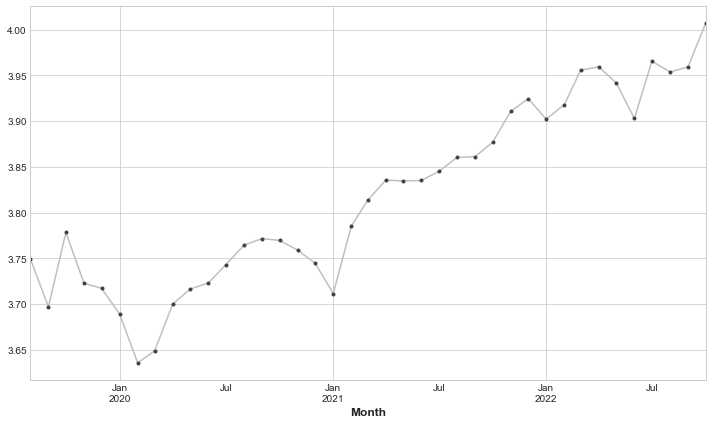

In [5]:
train_df['microbusiness_density'].groupby('Month').mean().plot(**plot_params)

### Trend model

#### Pivoted dataframe

In [6]:
# make pivot, setting date by index and cfips in columns
train_pivoted = train_df.pivot_table(index='Month', columns='cfips', values='microbusiness_density')
train_pivoted.head()

cfips,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
Month,,,,,,,,,,,,,,,,,,,,,
2019-08-01,3.007682,7.239156,1.073138,1.310777,1.544148,0.926372,0.674981,2.691544,1.486542,1.104277,...,1.150575,5.916088,4.062681,30.183279,6.115724,2.640386,26.433363,4.612016,2.603246,1.548594
2019-09-01,2.884870,7.290936,0.995794,1.305176,1.575892,0.998556,0.739265,2.703752,1.355156,1.089747,...,1.150575,5.894528,3.888567,31.712736,6.142085,2.858371,26.611856,4.338306,2.683593,1.530794
2019-10-01,3.055843,7.425439,1.160149,1.254761,1.546415,0.974495,0.713551,2.693764,1.355156,1.084903,...,1.150575,5.881592,3.903076,31.990431,6.181626,2.913635,26.736261,4.420419,2.635385,1.530794
2019-11-01,2.993233,7.426071,1.000628,1.254761,1.573625,1.022618,1.054256,2.739270,1.362664,1.084903,...,1.200600,5.954897,3.845038,32.776520,6.234348,3.008812,26.920164,4.372520,2.683593,1.601994
2019-12-01,2.993233,7.470274,1.000628,1.265965,1.555485,1.034649,1.054256,2.729281,1.343894,1.089747,...,1.200600,5.911776,3.845038,32.806427,6.273890,3.088637,26.903938,4.310935,2.635385,1.584194


### ETS Model

In [7]:
# divide em treino e teste
X_train = train_pivoted.iloc[:-4, :]
X_test = train_pivoted.iloc[-4:, :]
X_train.index = X_train.index.to_timestamp()
train_pivoted.index = train_pivoted.index.to_timestamp()
# X_train.info()

In [ ]:
# ets_df = pd.read_csv('./files/ETS_initial_params.csv', index_col=['cfips'], dtype={'seasonal_periods': np.int64})
# ets_df.sort_values('smape_ets_test', ascending=False).head(20)

In [ ]:
etsall_df = pd.read_csv('./files/ETS_best_params-all_cfips-all.csv',
                        index_col=['cfips'],
                        dtype={'seasonal_periods': np.int64})
etsall_df.sort_values('min_smape_ets_test', ascending=False).iloc[20:40]

In [ ]:
etsall_df.min_smape_ets_test.mean()

In [ ]:
cfip = 12001
model = ExponentialSmoothing(X_train[cfip], trend='add', damped_trend=True, seasonal='add',
                             seasonal_periods=12, initialization_method='estimated',
                            ).fit(optimized=True,
                                  use_brute=True,
                                  remove_bias=True,
                                  method='bh')

forecasts = model.forecast(4)
print('Forecasts:', '\n', forecasts)
print('\nSMAPE train: ', 100*2*np.mean(np.abs(X_train[cfip].values - model.fittedvalues.values)/(np.abs(X_train[cfip].values) + np.abs(model.fittedvalues.values))))
print('SMAPE test: ', 100*2*np.mean(np.abs(X_test[cfip].values - forecasts.values)/(np.abs(X_test[cfip].values) + np.abs(forecasts.values))))

In [ ]:
plt.figure(figsize=(8,6))
axs = X_train[cfip].plot(label='Original data', color='C0', style='.-', sharex=True)
X_test[cfip].plot(label='X_test', color='C0', ax=axs)
forecasts.plot(label='ETS Model', style='.-', color='C1', ax=axs)
model.fittedvalues.plot(label='fitted values', style='.-', color='C3')
plt.title(f'cfips {cfip} - Exponencial Smoothing' , fontsize=16)
# plt.ylabel("Monthly Sales Amount");
plt.xlabel("Month")
plt.legend();

In [ ]:
# residuals = X_train[cfip] - model.fittedvalues

res_df = pd.DataFrame(X_train[cfip]) #columns=['residual']
res_df['lag1'] = res_df[cfip].shift(1)
res_df.dropna(inplace=True)
res_df.head()

In [ ]:
res_df.plot(kind='scatter', x='lag1', y=cfip, figsize=(6,4));

### ETS submission file

In [ ]:
def ets_subfile(df_pivoted, test_df, etsall_df):
    
    df_list = []
    i=0
    for cfip in etsall_df.index:
        params = list(etsall_df.loc[cfip, 'trend':])
        params = [None if i is np.nan else i for i in params]
        #print(i+1, cfip, params)

        model = ExponentialSmoothing(df_pivoted[cfip], trend=params[0], damped_trend=params[1], seasonal=params[2],
                                    seasonal_periods=params[3], initialization_method=params[4],
                                    ).fit(optimized=True,
                                          use_brute=True,
                                          remove_bias=True,
                                          method='bh')
        forecasts = model.forecast(8)
        df = pd.DataFrame()
        df.index = forecasts.index
        df['cfips'] = cfip
        df['microbusiness_density'] = forecasts
        df_list.append(df)
        i+=1
        print(i, cfip)
    
    df = pd.concat(df_list, axis=0)
    df.index.names = ['Month']
    df = df.reset_index()
    
    df = df.assign(row_id = df.cfips.astype(str) + '_' + df.Month.astype(str))
    df = df.set_index('row_id', drop=True).drop(['Month','cfips'], axis=1)
    df = df.reset_index()
    
    sub_df = test_df.merge(df, how="left", on="row_id").drop(['cfips','first_day_of_month'], axis=1)
    empty_vals = sub_df['microbusiness_density'].isna().sum()
    
    return empty_vals, sub_df

empty_vals, sub_df = ets_subfile(train_pivoted, test_df, etsall_df)
sub_df.to_csv('./submission_files/subfinal_ETS_all-params_v0.csv', header=True, sep=",", index=False)
print('Empty Values: ', empty_vals)



### ARIMA model

### Augmented Dickey Fuller Test

Requirements for Stationary Series:

- **Critical Value (5%)  >  Test Statistic**
- **p-value  <  0.05**


In [45]:
def adf_reqs(train_df):
    
    df = pd.DataFrame(index=train_df.columns,
                      columns=['pvalue_diff0', 'pvalue_diff1', 'pvalue_diff2'])
    
    for cfip in df.index:
        
        adftest = adfuller(train_df[cfip], autolag='AIC')
        adftest_diff1 = adfuller(train_df[cfip].diff().dropna(), autolag='AIC')
        adftest_diff2 = adfuller(train_df[cfip].diff(2).dropna(), autolag='AIC')
        df.loc[cfip,:] = [adftest[1], adftest_diff1[1], adftest_diff2[1]]        
    
    for col in df.columns: df[col] = df[col].astype(float)
    
    # df = df.merge(df_notstat, how='left', on='cfips').fillna('yes')
    
    return df


In [46]:
adf_df = adf_reqs(train_pivoted)

In [49]:
adf_df[(adf_df.pvalue_diff0 > .05) & (adf_df.pvalue_diff1 < .05)]

,pvalue_diff0,pvalue_diff1,pvalue_diff2
cfips,,,
1001,0.994140,1.363992e-04,0.000439
1003,0.429866,8.847250e-07,0.009262
1007,0.065023,2.268072e-02,0.019039
1011,0.621501,2.298711e-08,0.884886
1013,0.742390,3.812275e-08,0.092734
...,...,...,...
56037,0.673201,5.455235e-05,0.116739
56039,0.595723,7.656332e-06,0.111468
56041,0.323520,6.889255e-08,0.003260


In [44]:
adf_df[adf_df.p_value <= .05]

,test_statistic,p_value,critical_value_5pct,stationary
cfips,,,,
1027,-3.148571,0.023161,-2.971989,yes
1041,-3.844185,0.002486,-2.951230,yes
1087,-4.160501,0.000768,-2.971989,yes
1101,-3.219331,0.018893,-2.951230,yes
1117,-3.149680,0.023088,-2.967882,yes
...,...,...,...,...
55103,-4.121243,0.000893,-2.941262,yes
55109,-3.370814,0.011995,-2.951230,yes
55111,-5.269031,0.000006,-2.960525,yes


In [36]:
arima_all = pd.read_csv('./files/ARIMA_best_pdq_p0-2_d0-1_q0-2_all-cfips.csv', index_col=['cfips'])
arima_all.sort_values('testset_min_smape', ascending=False).iloc[:30]

,trainset_smape,testset_min_smape,p,d,q
cfips,,,,,
28055,115.581571,200.000000,0,1,0
1133,7.309736,91.304566,1,0,1
12001,27.670389,62.484319,0,1,0
46053,7.896245,49.650081,1,1,1
26095,6.178460,48.951648,1,1,1
29063,1.844978,40.976772,0,1,0
20065,10.139735,34.538887,1,1,1
55011,6.811189,33.756719,0,1,0
18073,7.996262,32.786214,1,1,1


In [9]:
arima_all.testset_min_smape.mean()

2.045198789542708

In [ ]:
cfip=28031
arima_all.loc[cfip]

In [ ]:
model = ARIMA(train_pivoted[cfip], order=(1,1,1)).fit()
model.summary()

In [ ]:
pred = model.predict()
# residuals = train_pivoted[cfip] - pred
fore = model.predict(start=len(train_pivoted[cfip]), end=(len(train_pivoted[cfip])-1+8))

print('Forecasts:', '\n', fore)
print('\nSMAPE train: ', 100*2*np.mean(np.abs(train_pivoted[cfip].values - pred.values)/(np.abs(train_pivoted[cfip].values) + np.abs(pred.values))))
# print('SMAPE test: ', 100*2*np.mean(np.abs(X_test[cfip].values - fore.values)/(np.abs(X_test[cfip].values) + np.abs(fore.values))))

In [ ]:
plt.figure(figsize=(8,6))
axs = X_train[cfip].plot(label='Original data', color='C0', style='.-', sharex=True)
X_test[cfip].plot(label='X_test', color='C0', ax=axs)
fore.plot(label='ARIMA Model forecast', style='.-', color='C1', ax=axs)
pred[1:].plot(label='fitted values', style='.-', color='C3')
plt.title(f'cfips {cfip} - ARIMA' , fontsize=16)
# plt.ylabel("Monthly Sales Amount");
plt.xlabel("Month")
plt.legend();

In [ ]:
residuals[1:].plot()
plt.show()

In [ ]:
res_df = pd.DataFrame(residuals[1:], columns=['residual'])
res_df['lag1'] = res_df.residual.shift(1)
res_df.dropna(inplace=True)
res_df.head()

In [ ]:
res_df.plot(kind='scatter', x='lag1', y='residual')

### ARIMA submission file

In [10]:
def arima_subfile(df_pivoted, test_df, arima_all):
    
    df_list = []
    i=0
    for cfip in arima_all.index:
        params = list(arima_all.loc[cfip, 'p':])
        #print(i+1, cfip, params)

        model = ARIMA(df_pivoted[cfip], order=(params[0], params[1], params[2])).fit()
        
        forecasts = model.predict(start=len(df_pivoted[cfip]), end=(len(df_pivoted[cfip])+7))
        df = pd.DataFrame()
        df.index = forecasts.index
        df['cfips'] = cfip
        df['microbusiness_density'] = forecasts
        df_list.append(df)
        i+=1
        print(i, cfip)
    
    df = pd.concat(df_list, axis=0)
    df.index.names = ['Month']
    df = df.reset_index()
    
    df = df.assign(row_id = df.cfips.astype(str) + '_' + df.Month.astype(str))
    df = df.set_index('row_id', drop=True).drop(['Month','cfips'], axis=1)
    df = df.reset_index()
    
    sub_df = test_df.merge(df, how="left", on="row_id").drop(['cfips','first_day_of_month'], axis=1)
    empty_vals = sub_df['microbusiness_density'].isna().sum()
    
    return empty_vals, sub_df

empty_vals, sub_df = arima_subfile(train_pivoted, test_df, arima_all)
sub_df.to_csv('./submission_files/subfinal_ARIMA_best_pdq0to2_30bigtesterror_modifybyhand_v0.csv',
              header=True, sep=",", index=False)
print('Empty Values: ', empty_vals)


1 1001
2 1003
3 1005
4 1007
5 1009
6 1011
7 1013
8 1015
9 1017
10 1019
11 1021
12 1023
13 1025
14 1027
15 1029
16 1031
17 1033
18 1035
19 1037
20 1039
21 1041
22 1043
23 1045
24 1047
25 1049
26 1051
27 1053
28 1055
29 1057
30 1059
31 1061
32 1063
33 1065
34 1067
35 1069
36 1071
37 1073
38 1075
39 1077
40 1079
41 1081
42 1083
43 1085
44 1087
45 1089
46 1091
47 1093
48 1095
49 1097
50 1099
51 1101
52 1103
53 1105
54 1107
55 1109
56 1111
57 1113
58 1115
59 1117
60 1119
61 1121
62 1123
63 1125
64 1127
65 1129
66 1131
67 1133
68 2013
69 2016
70 2020
71 2050
72 2060
73 2068
74 2070
75 2090
76 2100
77 2105
78 2110
79 2122
80 2130
81 2150
82 2164
83 2170
84 2180
85 2185
86 2188
87 2195
88 2198
89 2220
90 2230
91 2240
92 2275
93 2282
94 2290
95 4001
96 4003
97 4005
98 4007
99 4009
100 4011
101 4012
102 4013
103 4015
104 4017
105 4019
106 4021
107 4023
108 4025
109 4027
110 5001
111 5003
112 5005
113 5007
114 5009
115 5011
116 5013
117 5015
118 5017
119 5019
120 5021
121 5023
122 5025
123 5027
1

865 19155
866 19157
867 19159
868 19161
869 19163
870 19165
871 19167
872 19169
873 19171
874 19173
875 19175
876 19177
877 19179
878 19181
879 19183
880 19185
881 19187
882 19189
883 19191
884 19193
885 19195
886 19197
887 20001
888 20003
889 20005
890 20007
891 20009
892 20011
893 20013
894 20015
895 20017
896 20019
897 20021
898 20023
899 20025
900 20027
901 20029
902 20031
903 20033
904 20035
905 20037
906 20039
907 20041
908 20043
909 20045
910 20047
911 20049
912 20051
913 20053
914 20055
915 20057
916 20059
917 20061
918 20063
919 20065
920 20067
921 20069
922 20071
923 20073
924 20075
925 20077
926 20079
927 20081
928 20083
929 20085
930 20087
931 20089
932 20091
933 20093
934 20095
935 20097
936 20099
937 20101
938 20103
939 20105
940 20107
941 20109
942 20111
943 20113
944 20115
945 20117
946 20119
947 20121
948 20123
949 20125
950 20127
951 20129
952 20131
953 20133
954 20135
955 20137
956 20139
957 20141
958 20143
959 20145
960 20147
961 20149
962 20151
963 20153
964 20155


1623 30053
1624 30055
1625 30057
1626 30059
1627 30061
1628 30063
1629 30065
1630 30067
1631 30069
1632 30071
1633 30073
1634 30075
1635 30077
1636 30079
1637 30081
1638 30083
1639 30085
1640 30087
1641 30089
1642 30091
1643 30093
1644 30095
1645 30097
1646 30099
1647 30101
1648 30103
1649 30105
1650 30107
1651 30109
1652 30111
1653 31001
1654 31003
1655 31005
1656 31007
1657 31009
1658 31011
1659 31013
1660 31015
1661 31017
1662 31019
1663 31021
1664 31023
1665 31025
1666 31027
1667 31029
1668 31031
1669 31033
1670 31035
1671 31037
1672 31039
1673 31041
1674 31043
1675 31045
1676 31047
1677 31049
1678 31051
1679 31053
1680 31055
1681 31057
1682 31059
1683 31061
1684 31063
1685 31065
1686 31067
1687 31069
1688 31071
1689 31073
1690 31075
1691 31077
1692 31079
1693 31081
1694 31083
1695 31085
1696 31087
1697 31089
1698 31091
1699 31093
1700 31095
1701 31097
1702 31099
1703 31101
1704 31103
1705 31105
1706 31107
1707 31109
1708 31111
1709 31113
1710 31115
1711 31119
1712 31121
1713 31123

2368 46019
2369 46021
2370 46023
2371 46025
2372 46027
2373 46029
2374 46031
2375 46033
2376 46035
2377 46037
2378 46039
2379 46041
2380 46043
2381 46045
2382 46047
2383 46049
2384 46051
2385 46053
2386 46055
2387 46057
2388 46059
2389 46061
2390 46063
2391 46065
2392 46067
2393 46069
2394 46071
2395 46073
2396 46075
2397 46077
2398 46079
2399 46081
2400 46083
2401 46085
2402 46087
2403 46089
2404 46091
2405 46093
2406 46095
2407 46097
2408 46099
2409 46101
2410 46103
2411 46105
2412 46107
2413 46109
2414 46111
2415 46115
2416 46117
2417 46119
2418 46121
2419 46123
2420 46125
2421 46127
2422 46129
2423 46135
2424 46137
2425 47001
2426 47003
2427 47005
2428 47007
2429 47009
2430 47011
2431 47013
2432 47015
2433 47017
2434 47019
2435 47021
2436 47023
2437 47025
2438 47027
2439 47029
2440 47031
2441 47033
2442 47035
2443 47037
2444 47039
2445 47041
2446 47043
2447 47045
2448 47047
2449 47049
2450 47051
2451 47053
2452 47055
2453 47057
2454 47059
2455 47061
2456 47063
2457 47065
2458 47067

3113 56001
3114 56003
3115 56005
3116 56007
3117 56009
3118 56011
3119 56013
3120 56015
3121 56017
3122 56019
3123 56021
3124 56023
3125 56025
3126 56027
3127 56029
3128 56031
3129 56033
3130 56035
3131 56037
3132 56039
3133 56041
3134 56043
3135 56045
Empty Values:  0


### SARIMA Model

In [ ]:
print(f'p-value adfuller {cfip}: ', adfuller(train_pivoted[cfip], autolag='AIC')[1])
print(f'p-value adfuller diff {cfip}: ', adfuller(train_pivoted[cfip].diff().dropna(), autolag='AIC')[1])
plot_acf(train_pivoted[cfip].diff().dropna());
plot_pacf(train_pivoted[cfip].diff().dropna());

In [ ]:
model_sarima = SARIMAX(X_train[cfip], order=(1,1,0), seasonal_order=(0, 0, 0, 12)).fit()
model_sarima.summary()

In [ ]:
pred = model_sarima.predict()
residuals = X_train[cfip] - pred
fore = model_sarima.predict(start=len(X_train[cfip]), end=(len(train_pivoted[cfip])-1))

print('Forecasts:', '\n', fore)
print('\nSMAPE train: ', 100*2*np.mean(np.abs(X_train[cfip].values - pred.values)/(np.abs(X_train[cfip].values) + np.abs(pred.values))))
print('SMAPE test: ', 100*2*np.mean(np.abs(X_test[cfip].values - fore.values)/(np.abs(X_test[cfip].values) + np.abs(fore.values))))

In [ ]:
plt.figure(figsize=(8,6))
axs = X_train[cfip].plot(label='Original data', color='C0', style='.-', sharex=True)
X_test[cfip].plot(label='X_test', color='C0', ax=axs)
fore.plot(label='ARIMA Model forecast', style='.-', color='C1', ax=axs)
pred[1:].plot(label='fitted values', style='.-', color='C3')
plt.title(f'cfips {cfip} - ARIMA' , fontsize=16)
# plt.ylabel("Monthly Sales Amount");
plt.xlabel("Month")
plt.legend();

In [ ]:
# calculate SMAPE between forecasts and actual values
def smape_error(y_pred, y_true):
    numerator = 2 * np.abs(y_true - y_pred)
    denominator = np.abs(y_pred) + np.abs(y_true)
        
    df = pd.DataFrame(index=range(max(numerator.shape)), columns=["Numerator", "Denominator"])
    df["Numerator"] = numerator.T
    df["Denominator"] = denominator.T
    
    df = df[df["Denominator"] != 0.0]   # Drop rows where column "Denominator" is equal to 0

    return 100 * np.mean(df["Numerator"].values/df["Denominator"].values)

In [ ]:
df_all = pd.read_csv('./files/ARIMA_best_pqd_p1-5_q1-5_d1-5_all-cfips.csv').dropna()
df_again = df_all.loc[(df_all['p'] == 4) | (df_all['q'] == 4) | (df_all['d'] == 4)]
df_train = X_train.loc[:, df_again['cfips']]
df_pivoted = train_pivoted.loc[:, df_again['cfips']]
df_test = X_test.loc[:, df_again['cfips']]

def best_pdq(df_train, df_pivoted, df_test):
    
    p, d, q = range(1,5), range(1,5), range(1,5)
    pdq_comb1 = list(itertools.product(p,d,q))   # return all possible combinations between the parameters
    p, d, q = range(1,7), range(1,7), range(1,7)
    pdq_comb2 = list(itertools.product(p,d,q))   # return all possible combinations between the parameters
    pdq_comb = list(set(pdq_comb2) - set(pdq_comb1))
    
    df = pd.DataFrame(index=list(df_train.columns), columns=['p', 'd', 'q', 'testset_smaller_smape'])
    df.index.name = df_train.columns.name
    i = 0
    for cfip in list(df.index)[600:1200]:
        error = []
        
        for pdq in pdq_comb:
            try:
                model = ARIMA(df_train[cfip], order=pdq).fit()
                pred = model.predict(start=len(df_train[cfip]), end=(len(df_pivoted[cfip])-1))   # 2022-07 to 2022-10
                error.append(smape_error(pred.values, df_test[cfip].values))
            except:
                error.append(400)
                continue
        i+=1
        print(i, len(error), len(pdq_comb))
        df.loc[cfip, :] = list(pdq_comb[error.index(min(error))]) + [min(error)]
    
    return df

df = best_pddq(df_train, df_pivoted, df_test)
df.to_csv('./files/ARIMA_best_pqd_p1-7_d1-7_q1-7_range_pt600_1200.csv', header=True, sep=",", index=True)


In [ ]:
df1 = pd.read_csv('./files/ETS_best_params_cfips0_1200.csv', index_col='cfips')
df1 = df1.iloc[:1200]
df2 = pd.read_csv('./files/ETS_best_params_cfips1200_1300.csv', index_col='cfips')
df2 = df2.iloc[1200:1300]
df3 = pd.read_csv('./files/ETS_best_params_cfips1300_1400.csv', index_col='cfips')
df3 = df3.iloc[1300:1400]
df4 = pd.read_csv('./files/ETS_best_params_cfips1400_1500.csv', index_col='cfips')
df4 = df4.iloc[1400:1500]
df5 = pd.read_csv('./files/ETS_best_params_cfips1500_1600.csv', index_col='cfips')
df5 = df5.iloc[1500:1600]
df6 = pd.read_csv('./files/ETS_best_params_cfips1600_1800.csv', index_col='cfips')
df6 = df6.iloc[1600:1800]
df7 = pd.read_csv('./files/ETS_best_params_cfips1800_2000.csv', index_col='cfips')
df7 = df7.iloc[1800:2000]
df8 = pd.read_csv('./files/ETS_best_params_cfips2000_2500.csv', index_col='cfips')
df8 = df8.iloc[2000:2500]
df9 = pd.read_csv('./files/ETS_best_params_cfips2500_3135.csv', index_col='cfips')
df9 = df9.iloc[2500:]


In [ ]:
df_all = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9], axis=0)
df_all.to_csv('./files/ETS_best_params-all_cfips-all.csv', header=True, sep=",", index=True)

In [ ]:
df_all

#### Trend features

In [ ]:
y = train_pivoted.copy()

# Create trend features
dp = DeterministicProcess(index=y.index,  # dates from the training data
                          order=2,        # quadratic trend
                          drop=True,      # drop terms to avoid collinearity
                          )

X = dp.in_sample()  # features for the training data
X.head()

#### Trend ML model

In [ ]:
# Test on 2022-10-01, last month training data. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(y.index, test_size=1, shuffle=False)

X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression()
model.fit(X_train, y_train)        # use same features (X_train) to fit both targets ('BuildingMaterials' and 'FoodAndBeverage')

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

y_train_copy, y_test_copy = y_train.copy(), y_test.copy()

In [ ]:
# Plot
cfips_ex = sample(list(train_pivoted.columns), 3)
axs = y_train_copy.loc[:, cfips_ex].plot(color='0.25', subplots=True, sharex=True, style='.-')
axs = y_test_copy.loc[:, cfips_ex].plot(color='C1', subplots=True, sharex=True, ax=axs, style='.-')
axs = y_fit.loc[:, cfips_ex].plot(color='C0', subplots=True, sharex=True, ax=axs, style='.-')
axs = y_pred.loc[:, cfips_ex].plot(color='C3', subplots=True, sharex=True, ax=axs, style='.-')
for ax in axs: ax.legend([])
_ = plt.suptitle(f"Trends - cfips {cfips_ex}")

### XGBoost model

#### Stacking dataframe

In [ ]:
X = pd.concat({'microbusinesses_density': train_pivoted}, names=[None, 'cfips'], axis=1).stack()
display(X.head())

y = X.pop("microbusinesses_density")
y.head()

In [ ]:
# reset index and separate by industries
X = X.reset_index('cfips')
X.head()

In [ ]:
# Label encoding for 'cfips' feature
for colname in X.select_dtypes(["int", "category"]):  #select_dtypes() returns dataframe with the columns matching the format
    X[colname], _ = X[colname].factorize()               #Encode the object as an enumerated type or categorical variable

X.head()

In [ ]:
# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12
X.head()

In [ ]:
# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [ ]:
X_train.head()

In [ ]:
y_train.head()

In [ ]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

In [ ]:
y_fit.head()

In [ ]:
# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

# Make predictions
y_fit_hybrid = pd.DataFrame(y_fit_boosted.unstack(),
                             index=y_fit_boosted.unstack().index,
                             columns=y_fit_boosted.unstack().columns,
                            )
y_pred_hybrid = pd.DataFrame(y_pred_boosted.unstack(),
                      index=y_pred_boosted.unstack().index,
                      columns=y_pred_boosted.unstack().columns,
                     )

# Sets negatives predicted values to 0
y_pred_hybrid[y_pred_hybrid < 0] = 0


In [ ]:
y_pred_hybrid.head(6)

In [ ]:
# Plot
cfips_ex = sample(list(train_pivoted.columns), 3)
axs = y_train_copy.loc[:, cfips_ex].plot(color='0.25', subplots=True, sharex=True, style='.-')
axs = y_test_copy.loc[:, cfips_ex].plot(color='C1', subplots=True, sharex=True, ax=axs, style='.-')
axs = y_fit_hybrid.loc[:, cfips_ex].plot(color='C0', subplots=True, sharex=True, ax=axs, style='.-')
axs = y_pred_hybrid.loc[:, cfips_ex].plot(color='C3', subplots=True, sharex=True, ax=axs, style='.-')
for ax in axs: ax.legend([])
_ = plt.suptitle(f"Trends - cfips {cfips_ex}")

### SMAPE

In [ ]:
# calculate SMAPE between forecasts and actual values
def smape(y_pred, y_true):
    numerator = 2 * np.abs(y_true - y_pred)
    denominator = np.abs(y_pred) + np.abs(y_true)
        
    df = pd.DataFrame(index=range(max(numerator.shape)), columns=["Numerator", "Denominator"])
    df["Numerator"] = numerator.T
    df["Denominator"] = denominator.T
    
    df = df[df["Denominator"] != 0.0]   # Drop rows where column "Denominator" is equal to 0

    return 100 * np.mean(df["Numerator"].values/df["Denominator"].values)


In [ ]:
SMAPE = smape(y_pred_hybrid.values, y_test_copy.values)
error = 200 * np.abs(y_pred_hybrid.values - y_test_copy.values) / (np.abs(y_pred_hybrid.values) + np.abs(y_test_copy.values))
error_df = pd.DataFrame(error.T, index=list(y_pred_hybrid.columns)).squeeze().fillna(0)

print("\nSMAPE error (): ", SMAPE)
print("\ncfips higher error: ")
print(error_df.sort_values(ascending=False), "\n")

# Plot
error_df.plot(**plot_params);

In [ ]:
error_df[error_df <= 1.09].sort_values(ascending=False)

### Error analysis

In [ ]:
# Plot
cfips_ex = error_df.sort_values(ascending=False).index[:5]
axs = y_train_copy.loc[:, cfips_ex].plot(color='0.25', subplots=True, sharex=True, style='.-')
axs = y_test_copy.loc[:, cfips_ex].plot(color='C1', subplots=True, sharex=True, ax=axs, style='.-')
axs = y_fit_hybrid.loc[:, cfips_ex].plot(color='C0', subplots=True, sharex=True, ax=axs, style='.-')
axs = y_pred_hybrid.loc[:, cfips_ex].plot(color='C3', subplots=True, sharex=True, ax=axs, style='.-')
for ax in axs: ax.legend([])
_ = plt.suptitle(f"Trends - cfips {cfips_ex}")